# Text Data Cleaning
## Setting up an API for HKJC Racing News

In [1]:
import requests
import json
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
baseURL = "https://newsapi.org/v2/everything?"
total_requests=2
verbose=True
API_KEY='c42b8e84aab24c85af001b27015206b3'
TOPIC='Hong Kong Jockey Club'

In [12]:
URLpost = {'apiKey': API_KEY,
            'q': '+'+TOPIC,
            'sortBy': 'relevancy',
            'totalRequests': 1}

print(baseURL)
# print(URLpost)

#GET DATA FROM API
response = requests.get(baseURL, URLpost) #request data from the server
# print(response.url);  
response = response.json() #extract txt data from request into json

print(json.dumps(response, indent=2))

# #GET TIMESTAMP FOR PULL REQUEST
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d-H%H-M%M-S%S")

# SAVE TO FILE 
with open(timestamp+'-newapi-raw-data.json', 'w') as outfile:
    json.dump(response, outfile, indent=4)

https://newsapi.org/v2/everything?
{
  "status": "ok",
  "totalResults": 5,
  "articles": [
    {
      "source": {
        "id": null,
        "name": "Forbes"
      },
      "author": "Zinnia Lee, Forbes Staff, \n Zinnia Lee, Forbes Staff\n https://www.forbes.com/sites/zinnialee/",
      "title": "This Social Enterprise Backed By Swire And Nan Fung\u2019s Chen Family Is Teaching Emotional Education In Exam-Obsessed Hong Kong",
      "description": "The lack of emotional education in Hong Kong's exam-oriented system inspired Anthony Ngai, Matthew Kwok and Raymond Yang to establish Just Feel.",
      "url": "https://www.forbes.com/sites/zinnialee/2023/09/04/this-social-enterprise-backed-by-swire-and-nan-fungs-chen-family-is-teaching-emotional-education-in-exam-obsessed-hong-kong/",
      "urlToImage": "https://imageio.forbes.com/specials-images/imageserve/64ef0f6fb3f3f3e2a24af6bd/0x0.jpg?format=jpg&crop=2861,1609,x0,y0,safe&width=1200",
      "publishedAt": "2023-09-05T03:00:43Z",
    

In [13]:
def string_cleaner(input_string):
    try: 
        out=re.sub(r"""
                    [,.;@#?!&$-]+  # Accept one or more copies of punctuation
                    \ *           # plus zero or more copies of a space,
                    """,
                    " ",          # and replace it with a single space
                    input_string, flags=re.VERBOSE)

        #REPLACE SELECT CHARACTERS WITH NOTHING
        out = re.sub('[’.]+', '', input_string)

        #ELIMINATE DUPLICATE WHITESPACES USING WILDCARDS
        out = re.sub(r'\s+', ' ', out)

        #CONVERT TO LOWER CASE
        out=out.lower()
    except:
        print("ERROR")
        out=''
    return out

In [14]:
article_list=response['articles']   #list of dictionaries for each article
article_keys=article_list[0].keys()
print("AVAILABLE KEYS:")
print(article_keys)
index=0
cleaned_data=[];  
for article in article_list:
    tmp=[]
    if(verbose):
        print("#------------------------------------------")
        print("#",index)
        print("#------------------------------------------")

    for key in article_keys:
        if(verbose):
            print("----------------")
            print(key)
            print(article[key])
            print("----------------")

        if(key=='source'):
            src=string_cleaner(article[key]['name'])
            tmp.append(src) 

        if(key=='author'):
            author=string_cleaner(article[key])
            #ERROR CHECK (SOMETIMES AUTHOR IS SAME AS PUBLICATION)
            if(src in author): 
                print(" AUTHOR ERROR:",author);author='NA'
            tmp.append(author)

        if(key=='title'):
             tmp.append(string_cleaner(article[key]))

        if(key=='description'):
            tmp.append(string_cleaner(article[key]))

        # if(key=='content'):
        #     tmp.append(string_cleaner(article[key]))

        if(key=='publishedAt'):
            #DEFINE DATA PATERN FOR RE TO CHECK  .* --> wildcard
            ref = re.compile('.*-.*-.*T.*:.*:.*Z')
            date=article[key]
            if(not ref.match(date)):
                print(" DATE ERROR:",date); date="NA"
            tmp.append(date)

    cleaned_data.append(tmp)
    index+=1



AVAILABLE KEYS:
dict_keys(['source', 'author', 'title', 'description', 'url', 'urlToImage', 'publishedAt', 'content'])
#------------------------------------------
# 0
#------------------------------------------
----------------
source
{'id': None, 'name': 'Forbes'}
----------------
----------------
author
Zinnia Lee, Forbes Staff, 
 Zinnia Lee, Forbes Staff
 https://www.forbes.com/sites/zinnialee/
----------------
 AUTHOR ERROR: zinnia lee, forbes staff, zinnia lee, forbes staff https://wwwforbescom/sites/zinnialee/
----------------
title
This Social Enterprise Backed By Swire And Nan Fung’s Chen Family Is Teaching Emotional Education In Exam-Obsessed Hong Kong
----------------
----------------
description
The lack of emotional education in Hong Kong's exam-oriented system inspired Anthony Ngai, Matthew Kwok and Raymond Yang to establish Just Feel.
----------------
----------------
url
https://www.forbes.com/sites/zinnialee/2023/09/04/this-social-enterprise-backed-by-swire-and-nan-fung

In [34]:
import numpy as np
df = pd.DataFrame(cleaned_data)
title = str(np.array(df[2]))
descr = str(np.array(df[3]))
text = title + descr
text = text.replace('"', '')
text = text.replace("'","")
text = text.replace(".","")

## Here is a Word Cloud to take a glimpse into the text data

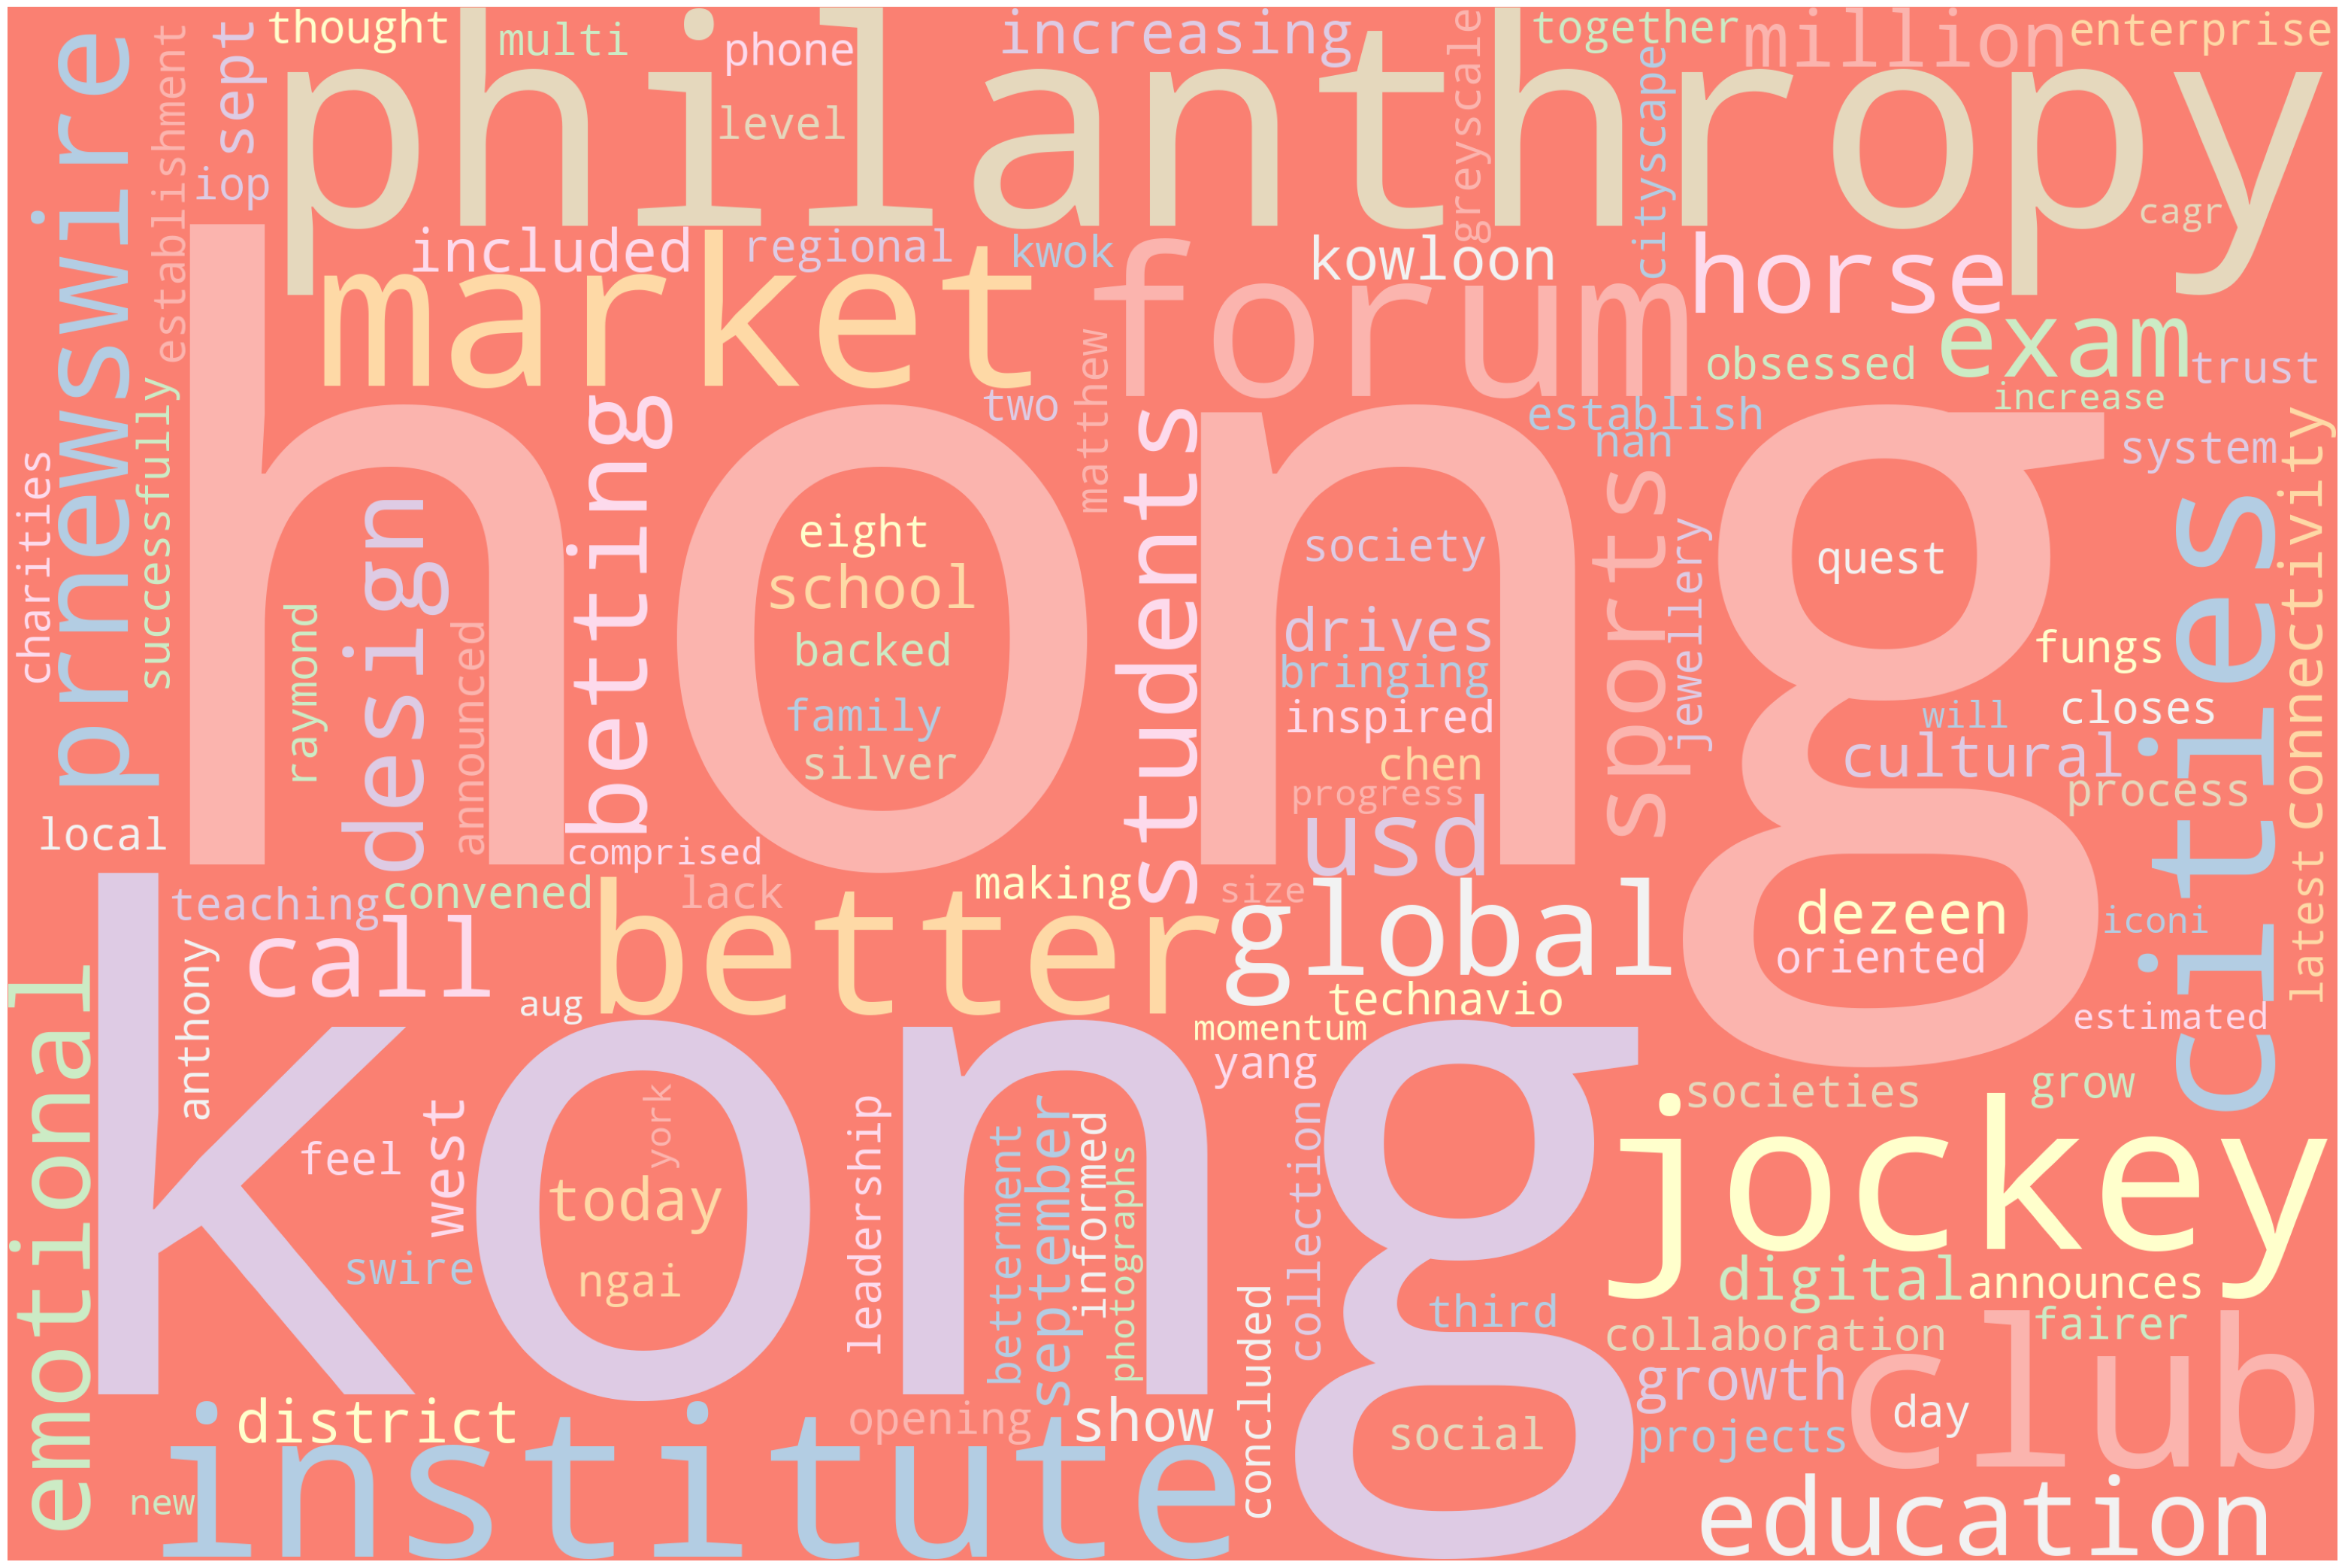

In [16]:
def generate_word_cloud(my_text):
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    # exit()
    # Import package
    # Define a function to plot word cloud
    def plot_cloud(wordcloud):
        # Set figure size
        plt.figure(figsize=(40, 30))
        # Display image
        plt.imshow(wordcloud) 
        # No axis details
        plt.axis("off");

    # Generate word cloud
    wordcloud = WordCloud(
        width = 3000,
        height = 2000, 
        random_state=1, 
        background_color='salmon', 
        colormap='Pastel1', 
        collocations=False,
        stopwords = STOPWORDS).generate(my_text)
    plot_cloud(wordcloud)
    plt.show()

    
generate_word_cloud(text)

## Count Vectorizer

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = text.split()
vectorizer = CountVectorizer()
Xs = vectorizer.fit_transform(corpus)

In [39]:
print("vocabulary = ", vectorizer.vocabulary_)


vocabulary =  {'this': 129, 'social': 117, 'enterprise': 46, 'backed': 15, 'by': 20, 'swire': 123, 'and': 9, 'nan': 93, 'fungs': 57, 'chen': 24, 'family': 52, 'is': 73, 'teaching': 125, 'emotional': 45, 'education': 43, 'in': 65, 'exam': 50, 'obsessed': 96, 'hong': 62, 'kong': 77, 'jockey': 75, 'club': 28, 'closes': 27, 'philanthropy': 100, 'for': 54, 'better': 16, 'cities': 25, 'forum': 55, 'with': 139, 'call': 22, 'global': 58, 'multi': 92, 'level': 84, 'collaboration': 29, 'quest': 107, 'fairer': 51, 'societies': 118, 'announces': 11, 'institute': 71, 'of': 97, 'bringing': 19, 'together': 133, 'local': 85, 'regional': 109, 'thought': 130, 'leadership': 83, 'the': 127, 'betterment': 17, 'society': 119, 'eight': 44, 'projects': 106, 'students': 121, 'at': 13, 'design': 37, 'horse': 63, 'sports': 120, 'betting': 18, 'market': 87, 'to': 131, 'grow': 60, 'usd': 136, '17187': 2, 'million': 90, 'from': 56, '2022': 3, '2027': 5, 'increasing': 68, 'digital': 40, 'connectivity': 33, 'drives':

Once again for the grader: I will clean this up way more in the future and add more description on what I am doing. For now, I am trying to just lay the groundwork.